### Мини проект по Извличане на Закономерности от Данни

#### Антон Петков, МП Изкуствен Интелект, фн. 25915, anton.petkoff@gmail.com

In [1]:
%matplotlib inline

import math
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from functools import reduce

In [2]:
df = pd.read_csv('data/bc.data', names=[
    'age',
    'menopause',
    'tumor-size',
    'inv-nodes',
    'node-caps',
    'deg-malig',
    'breast',
    'breast-quad',
    'irradiat',
    'class'
])

# слагане на нули пред единичните цифри, за да има е валидна лексикографската сортировка на данните
df['tumor-size'] = df['tumor-size'].replace(' 5-9', ' 05-09').replace(' 0-4', ' 00-04')

df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events


## Формули

### Средно-аритметична стойност

За намирането на средно-аритметичната стойност се използва формула (2.3) от Лекция 2.

In [3]:
# interval_string is a string with the format 'a-b', e.g. '50-59'
def get_interval_mean(interval_string):
    a, b = list(map(float, interval_string.split('-')))
    return (a + b) / 2 # TODO: overlapping intervals?

def get_binned_mean(series):
    counts = series.value_counts().to_dict().items()
    sum = reduce(lambda acc, x: acc + get_interval_mean(x[0]) * x[1], counts, 0)
    return sum / series.size

### Медиана, Q1 и Q3

За апроксимирането на медианата се използва формула (2.4) от Лекция 2.
Тя е адаптирана и за намирането на Q1 и Q3, като е обобщена да намира посочен квантил.

In [4]:
def approximate_quantile(series, quantile = 0.5):
    sorted_series = series.sort_values().reset_index(drop=True)
    N = math.floor((series.size + 1) * quantile) - 1 # index from zero

    cumsum = series.value_counts().sort_index().cumsum()
    group_key = sorted_series[N]
    group_index = cumsum.index.get_loc(group_key)
    previous_group_index = group_index - 1 # TODO: clamp to zero?
    previous_cumsum = cumsum[cumsum.index[previous_group_index]]

    L, H = list(map(float, group_key.split('-')))
    
    group_size = cumsum[group_key] - previous_cumsum
    
    return L + (N - previous_cumsum) * ((H - L) / group_size)

### Мода

За апроксимирането на модата на данните се използва формула (2.5) от Лекция 2.

In [5]:
def approximate_mode(series):
    value_counts = series.value_counts().sort_index()

    mode_key = value_counts.sort_values(ascending=False).index[0]
    
    L, H = list(map(float, mode_key.split('-')))

    mode_index = value_counts.index.get_loc(mode_key)

    cur_count = value_counts[mode_index]
    prev_count = value_counts[mode_index - 1]
    next_count = value_counts[mode_index + 1]

    return L + ((cur_count - prev_count) * (H - L)) / (2 * cur_count - prev_count - next_count)

In [6]:
# помощна функция за изчисляване на всички статистики за първите 6 задачи

def get_stats(series):
    mean = get_binned_mean(series)
    mode = approximate_mode(series)
    
    median = approximate_quantile(series)
    q1 = approximate_quantile(series, quantile=1/4)
    q3 = approximate_quantile(series, quantile=3/4)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr

    return {
        'mean': mean,
        'mode': mode,
        'median': median,
        'q1': q1,
        'q3': q3,
        'xmin': max(0, lower_fence), # age and tumor size cannot be negative
        'xmax': upper_fence,
    }

In [7]:
# функции за чертаене на boxplot

def get_boxplot_stats(stats, label):
    return {
        'med': stats['median'],
        'q1': stats['q1'],
        'q3': stats['q3'],
        'whislo': stats['xmin'],
        'whishi': stats['xmax'],
        'label': label
    }

def draw_boxplot(stats, label):
    boxplot_stats = get_boxplot_stats(stats, label)

    fig, ax = plt.subplots(1, 1)
    
    fig.set_size_inches(5, 6)
    ax.bxp([boxplot_stats], showfliers=False)

In [8]:
def print_summary(stats):
    print('Средно аритметично: {}'.format(stats['mean']))
    print('Медиана: {}'.format(stats['median']))
    print('Мода: {}'.format(stats['mode']))
    print()
    print('Xmin: {}'.format(stats['xmin']))
    print('Q1: {}'.format(stats['q1']))
    print('Q2 (Медиана): {}'.format(stats['median']))
    print('Q3: {}'.format(stats['q3']))
    print('Xmax: {}'.format(stats['xmax']))

## 1. Каква е средната възраст на жени, заболели от рак на гърдата?

In [9]:
stats_age = get_stats(df.age)
print_summary(stats_age)

Средно аритметично: 51.14335664335665
Медиана: 51.40625
Мода: 51.2

Xmin: 21.015624999999993
Q1: 43.3
Q2 (Медиана): 51.40625
Q3: 58.15625
Xmax: 80.44062500000001


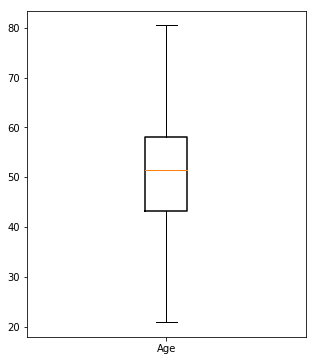

In [10]:
draw_boxplot(stats_age, label='Age')

## 2. Каква е средната възраст на жени, при които се забелязва повтаряне на рака на гърдата след проведената операция?


In [11]:
df_age_recurrence = df[df['class'] == ' recurrence-events'].age
stats_age_recurrence = get_stats(df_age_recurrence)
print_summary(stats_age_recurrence)

Средно аритметично: 50.029411764705884
Медиана: 50.0
Мода: 47.714285714285715

Xmin: 17.826666666666657
Q1: 41.666666666666664
Q2 (Медиана): 50.0
Q3: 57.56
Xmax: 81.4


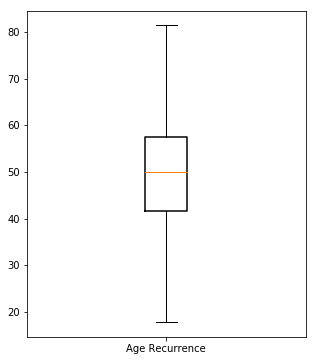

In [12]:
draw_boxplot(stats_age_recurrence, label='Age Recurrence')

## 3. Каква е средната възраст на жени, при които не се забелязва повтаряне на рака на гърдата след проведената операция (т.е. се смятат за излекувани)?


In [13]:
df_age_no_recurrence = df[df['class'] == ' no-recurrence-events'].age
stats_age_no_recurrence = get_stats(df_age_no_recurrence)
print_summary(stats_age_no_recurrence)

Средно аритметично: 51.614427860696516
Медиана: 51.901408450704224
Мода: 51.84615384615385

Xmin: 22.283702213279668
Q1: 43.857142857142854
Q2 (Медиана): 51.901408450704224
Q3: 58.23943661971831
Xmax: 79.8128772635815


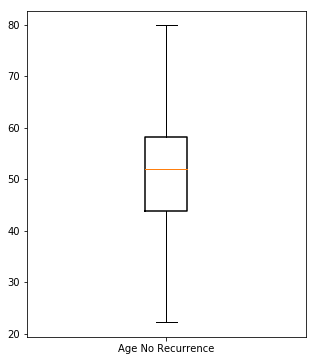

In [14]:
draw_boxplot(stats_age_no_recurrence, label='Age No Recurrence')

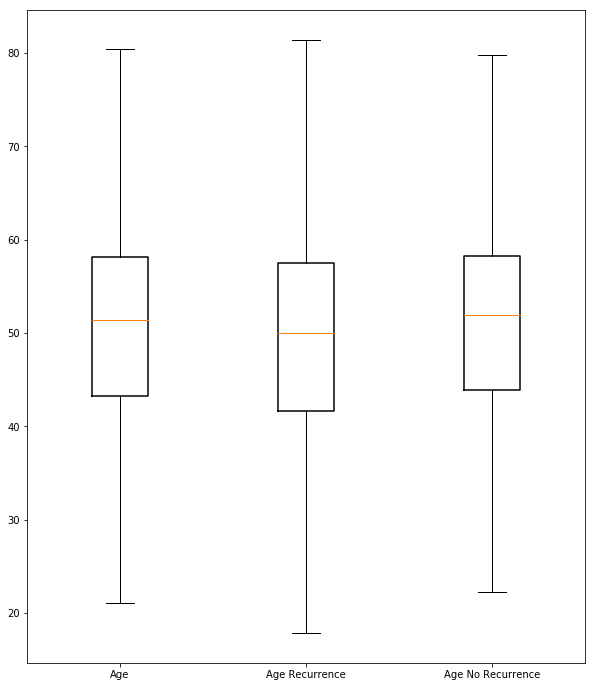

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 12)

plot = ax.bxp([
    get_boxplot_stats(stats_age, 'Age'),
    get_boxplot_stats(stats_age_recurrence, 'Age Recurrence'),
    get_boxplot_stats(stats_age_no_recurrence, 'Age No Recurrence')
], showfliers=False)

## Анализ на средната възраст

От дадените boxplot графики не се забелязва драстична разлика между трите групи данни.
    
Това, което се забелязва, е че интервалът на възраст на жени, при които се забелязва повтаряне на рака на гърдата след проведената операция, е по-широк от този интервал на жени, при които НЕ се забелязва повтаряне на рака на гърдата след операция.
    
Освен това, модата при средната група (от трите разгледани) е 47.71, докато при другите две групи е 51.2 и 51.85, които са по-близо до медианата и средно-аритметичната стойност.

## 4. Какъв е средният  размер на тумора на жени, заболели от рак на гърдата?

In [16]:
stats_tumor = get_stats(df['tumor-size'])
print_summary(stats_tumor)

Средно аритметично: 26.405594405594407
Медиана: 26.62962962962963
Мода: 30.51063829787234

Xmin: 1.0000000000000036
Q1: 20.0
Q2 (Медиана): 26.62962962962963
Q3: 32.666666666666664
Xmax: 51.66666666666666


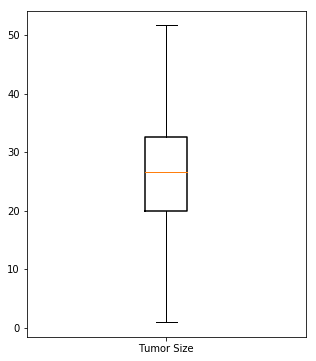

In [17]:
draw_boxplot(stats_tumor, 'Tumor Size')

## 5. Какъв е средният  размер на тумора на жени, при които се забелязва повтаряне на рака на гърдата след проведената операция?

In [18]:
df_tumor_recurrence = df[df['class'] == ' recurrence-events']['tumor-size']
stats_tumor_recurrence = get_stats(df_tumor_recurrence)
print_summary(stats_tumor_recurrence)

Средно аритметично: 29.235294117647058
Медиана: 28.77777777777778
Мода: 31.12

Xmin: 7.074999999999996
Q1: 22.75
Q2 (Медиана): 28.77777777777778
Q3: 33.2
Xmax: 48.87500000000001


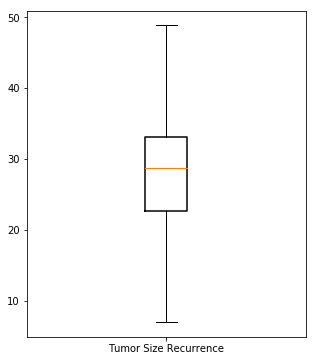

In [19]:
draw_boxplot(stats_tumor_recurrence, label='Tumor Size Recurrence')

## 6. Какъв е средният  размер на тумора на жени, при които не се забелязва повтаряне на рака на гърдата след проведената операция (т.е. се смятат за излекувани)?

In [20]:
df_tumor_no_recurrence = df[df['class'] == ' no-recurrence-events']['tumor-size']
stats_tumor_no_recurrence = get_stats(df_tumor_no_recurrence)
print_summary(stats_tumor_no_recurrence)

Средно аритметично: 25.208955223880597
Медиана: 25.555555555555557
Мода: 27.666666666666668

Xmin: 0
Q1: 16.91304347826087
Q2 (Медиана): 25.555555555555557
Q3: 32.17142857142857
Xmax: 55.05900621118012


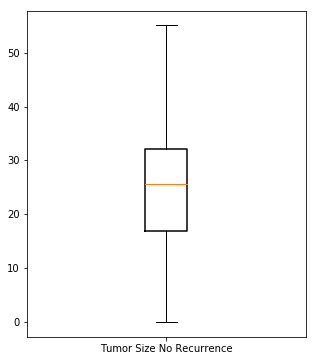

In [21]:
draw_boxplot(stats_tumor_no_recurrence, label='Tumor Size No Recurrence')

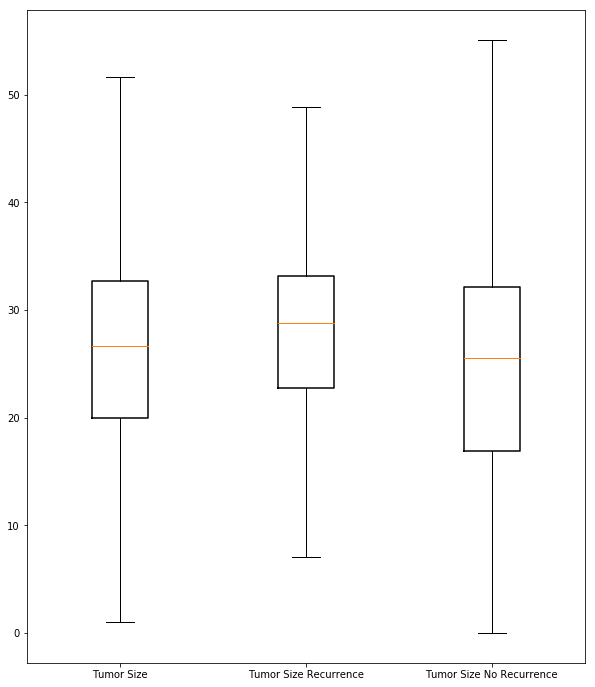

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 12)

plot = ax.bxp([
    get_boxplot_stats(stats_tumor, 'Tumor Size'),
    get_boxplot_stats(stats_tumor_recurrence, 'Tumor Size Recurrence'),
    get_boxplot_stats(stats_tumor_no_recurrence, 'Tumor Size No Recurrence')
], showfliers=False)

## Анализ на среден размер на тумора

От трите boxplot графики, наредени една до друга се забелязва по-съсредоточено разпределение на данни около медианата във втората графика Tumor Size Recurrence, където са всички жени, при които се наблюдава болестта повторно.

Първата и третата графика имат сходна структура с по-разпръснати наблюдения, тоест по-голям интервал между Xmin и Xmax.

## 7. Проверете, има ли зависимост между възрастта на заболелите жени и размера на тумора.

### 1. Чрез построяване на графика на разсейване (scatter plot)

Първо осредняваме стойностите на размера на тумора за всяка средна възраст.

In [23]:
df['mean-age'] = df.age.apply(get_interval_mean)
df['mean-tumor'] = df['tumor-size'].apply(get_interval_mean)

def mean_tumor_by_age(df):
    return df[['mean-age', 'mean-tumor']].groupby('mean-age').mean().reset_index()

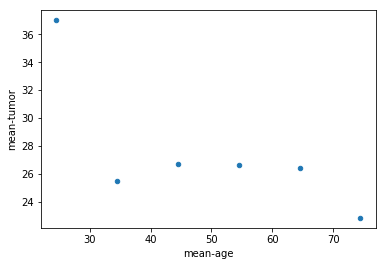

In [24]:
# 1) За всички жени, заболели от рак

df_tumor_by_age = mean_tumor_by_age(df)
plot = df_tumor_by_age.plot.scatter(x='mean-age', y='mean-tumor')

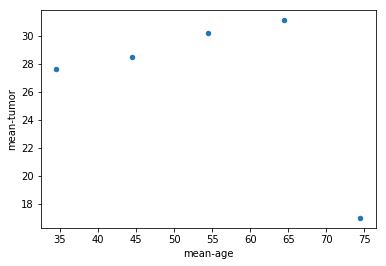

In [25]:
# 2) Само за жени, за които е забелязано повтаряне на рака след проведената операция.

df_tumor_by_age_rec = mean_tumor_by_age(df[df['class'] == ' recurrence-events'])
plot = df_tumor_by_age_rec.plot.scatter(x='mean-age', y='mean-tumor')

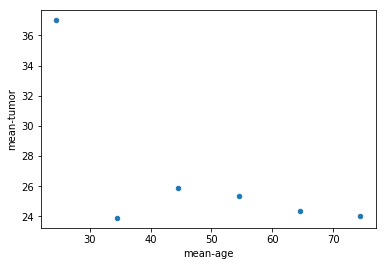

In [26]:
# 3) Само за жени, за които не е забелязано повтаряне на рака след отстраняване на тумора.

df_tumor_by_age_no_rec = mean_tumor_by_age(df[df['class'] == ' no-recurrence-events'])
plot = df_tumor_by_age_no_rec.plot.scatter(x='mean-age', y='mean-tumor')

## Анализ на графики на разсейване (scatter plot)

Първата и третата графика на разсейване не се отличават една от друга много. Това са цялата група от жени болни от рак и съответно групата от жени, при които не се е наблюдавал рак повторно.

Интересна е втората графика, при която има само жени с повторно наблюдаване на заболяването, където размерът на тумора и възрастта на жените имат лека корелация. Тоест при по-възрастни жени, се наблюдава по-голям размер на тумора.

### 2. Чрез изчисляване на коефициента на корелация между двете променливи. 

In [27]:
# 1) За всички жени, заболели от рак

df_tumor_by_age.corr()

,mean-age,mean-tumor
mean-age,1.00000,-0.74696
mean-tumor,-0.74696,1.00000


In [28]:
# 2) Само за жени, за които е забелязано повтаряне на рака след проведената операция.

df_tumor_by_age_rec.corr()

,mean-age,mean-tumor
mean-age,1.000000,-0.519011
mean-tumor,-0.519011,1.000000


In [29]:
# 3) Само за жени, да които не е забелязано повтаряне на рака след отстраняване на тумора.

df_tumor_by_age_no_rec.corr()

,mean-age,mean-tumor
mean-age,1.000000,-0.674585
mean-tumor,-0.674585,1.000000


## Анализ на коефициенти на корелация между възраст и размер на тумор

На първият scatter plot и на втория също се забелязва, че жени под 30 години имат много голям среден размер на тумора над 36, който се отличава значително повече от останалите стойности. Тази аномалия не се забелязва във втората група от жени, при които се наблюдава повтаряне на болестта.

При втората група пък жените в най-напреднала възраст над 70 години имат най-малък среден размер на тумора под 20, но преобладаващата средна стойност на размера на тумора е по-голяма с 2 до 4 единици повече от другите две групи от жени.

Тези аномалии влияят за отрицателната корелация разгледана по-долу.

При цялата група от жени с рак и при групата от жени без повторно наблюдаване на болестта се забелязва най-силна обратна корелация, тоест с нарастването на средната възраст намалява средния размер на тумора. Същата обратна корелация се наблюдава и във втората група, но в по-малка степен.